# Localization

After achieving amazing result in classification. We are going to now do localization.

In [2]:
import os
import torch
import json
import torchvision
from PIL import Image
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
from skimage import io, transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from collections import OrderedDict
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

## Loading and Pre-processing the data

Again we are using the same dataset we used for classifiaction. It has 61 Images. I have labeled all images using lebelImg and annotations are stored in `annotations.json`

In [3]:
root_dir = '.'

Here we can't we `ImageFolder` or some other inbuilt datasets class so we have to write a custom dataset classs.

Let's see how our annotations look

In [4]:
with open('annotations.json') as f:
    json_file = json.load(f)

In [5]:
# smaple annotation
json_file[3]

{'annotations': [{'xmin': 363, 'ymin': 53, 'xmax': 750, 'ymax': 371}],
 'class': 'spill',
 'file': 'cup_data/spill/2019-06-11-171929_9.jpg'}

In [6]:
class CupDataset(Dataset):
    """Cup Dataset"""
    
    def __init__(self, json_file, root_dir, transform=None):
        self.anno = pd.read_json(json_file)
        self.anno = self.anno.set_index('file')
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.anno)
    
    def __getitem__(self, idx):
        img_name = self.anno.iloc[idx].name
        img_path = os.path.join(self.root_dir, img_name)
        image = io.imread(img_path)
        d = self.anno.loc[img_name].annotations[0]
        xmin, ymin, xmax, ymax = d['xmin'], d['ymin'], d['xmax'], d['ymax']
        bb_cords = np.array([xmin, ymin, xmax, ymax])
        sample = {'image': image, 'bb_cords': bb_cords}
        
        if self.transform:
            sample  = self.transform(sample)
        return sample

### Transforms

We have to transform image as well as bounding box cordinates

In [85]:
class Resize(object):
    """Resize the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, bb_cords = sample['image'], sample['bb_cords']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h   
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        bb_cords[0::2] = bb_cords[0::2] * (new_w / w)
        bb_cords[1::2] = bb_cords[1::2] * (new_h / h)
#         bb_cords = bb_cords * [new_w / w, new_h / h]
        
        return {'image': img, 'bb_cords': bb_cords}

In [86]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bb_cords = sample['image'], sample['bb_cords']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'bb_cords': torch.from_numpy(bb_cords)}

In [87]:
class Normalize(object):
    def __call__(self, sample):
        image, bb_cords = sample['image'], sample['bb_cords']
        
        imgnet_norm = transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
        image = imgnet_norm(image.float())
        
        return {'image': image, 'bb_cords': bb_cords}

In [88]:
#transforms
tfms = transforms.Compose([Resize((224,224)), ToTensor(), Normalize()])

In [89]:
cup_dataset = CupDataset(json_file='annotations.json', root_dir='.', transform=tfms)

In [90]:
cup_dataset[0]

{'image': tensor([[[ 1.8985,  1.7824,  1.7042,  ..., -1.2299, -0.9493, -1.0782],
          [ 1.8495,  1.7682,  1.7021,  ..., -0.9864, -0.8776, -1.1199],
          [ 1.7945,  1.7590,  1.7046,  ..., -1.0011, -1.0390, -1.1237],
          ...,
          [ 1.2557,  1.2550,  1.2142,  ...,  0.3292,  0.3322,  0.3309],
          [ 1.2693,  1.2781,  1.2844,  ...,  0.3426,  0.3254,  0.3555],
          [ 1.2899,  1.3395,  1.3242,  ...,  0.3823,  0.3663,  0.3652]],
 
         [[ 1.7164,  1.7821,  1.8665,  ..., -0.7096, -0.4276, -0.4288],
          [ 1.7170,  1.7756,  1.8146,  ..., -0.6139, -0.4713, -0.6339],
          [ 1.7141,  1.7539,  1.7788,  ..., -0.6233, -0.6445, -0.7339],
          ...,
          [ 1.3640,  1.3782,  1.3688,  ...,  0.4328,  0.4077,  0.4153],
          [ 1.3613,  1.3900,  1.4295,  ...,  0.4622,  0.4096,  0.4153],
          [ 1.3844,  1.4463,  1.4653,  ...,  0.5024,  0.4515,  0.4153]],
 
         [[ 2.1265,  2.0444,  2.0785,  ...,  0.1395,  0.3057,  0.0922],
          [ 2.0843,

## Visualize Images

Let's visualise some images and oberve if all transformations are applied correctly on the dataset

In [91]:
# function for drawing bounding box
from matplotlib.patches import Rectangle
def draw_bb(image, bb_cords, kind='numpy', normalized=True, testing=False):
    if kind == 'tensor':
        # covert to numpy as swap color axis
        image = image.numpy().transpose((1, 2, 0))
    if normalized:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        # un-normailze
        image = std * image + mean
        image = np.clip(image, 0, 1)   # what does this do?
    # color of bounding box
    # draw different color box while prediction
    c = 'r'
    if testing:
        c = 'g'
    plt.imshow(image)
    # get current axis
    ax = plt.gca()
    b = bb_cords
    # (xmin, ymin), xmax-xmin, ymax-ymin
    rect = Rectangle((b[0],b[1]),b[2]-b[0],b[3]-b[1],linewidth=2,edgecolor=c,facecolor='none')
    ax.add_patch(rect)

0 torch.Size([3, 224, 224]) torch.Size([4])
1 torch.Size([3, 224, 224]) torch.Size([4])
2 torch.Size([3, 224, 224]) torch.Size([4])
3 torch.Size([3, 224, 224]) torch.Size([4])


<Figure size 432x288 with 0 Axes>

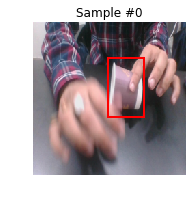

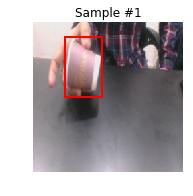

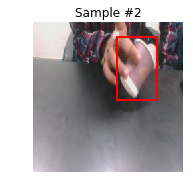

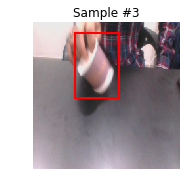

In [95]:
fig = plt.figure()
for i in range(len(cup_dataset)):
    sample = cup_dataset[i]
    fig = plt.figure(figsize=(10,10))
    print(i, sample['image'].shape, sample['bb_cords'].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    draw_bb(**sample, kind='tensor')

    if i == 3:
        plt.show()
        break

In [96]:
# size of the dataset
len(cup_dataset)

61

In [97]:
# split data in train and validaion
bs=4
validation_split = .1
shuffle_dataset = True
random_seed= 42

dataset_size = len(cup_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(cup_dataset, batch_size=bs, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(cup_dataset, batch_size=bs,
                                                sampler=valid_sampler)

## Model

In [182]:
model = models.densenet121(pretrained=True)
# Freeze model parameters, so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
fc_in_size = model.classifier.in_features
model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(fc_in_size, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 4))
                          ]))

In [185]:
criterion = nn.MSELoss()

In [186]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.0003)

In [187]:
def train_net(n_epochs):
    # prepare the net for training
    model.train()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            bb_cords = data['bb_cords']
            # flatten pts, no use here
            bb_cords = bb_cords.view(bb_cords.size(0), -1)
            # convert variables to floats for regression loss
            bb_cords = bb_cords.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            # forward pass to get outputs
            output_pts = model(images)
            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, bb_cords)
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            # backward pass to calculate the weight gradients
            loss.backward()
            # update the weights
            optimizer.step()
            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [188]:
train_net(10)

Epoch: 1, Batch: 10, Avg. Loss: 3.9266722259521485
Epoch: 2, Batch: 10, Avg. Loss: 4.4026597900390625
Epoch: 3, Batch: 10, Avg. Loss: 4.22697721862793
Epoch: 4, Batch: 10, Avg. Loss: 4.683600318908692
Epoch: 5, Batch: 10, Avg. Loss: 3.99664436340332
Epoch: 6, Batch: 10, Avg. Loss: 4.066813613891601
Epoch: 7, Batch: 10, Avg. Loss: 3.873167236328125
Epoch: 8, Batch: 10, Avg. Loss: 4.20601237487793
Epoch: 9, Batch: 10, Avg. Loss: 3.5908176498413087
Epoch: 10, Batch: 10, Avg. Loss: 3.3023356018066408
Finished Training


In [189]:
model.training

True

In [190]:
model.eval();

In [192]:
batch = next(iter(validation_loader))
imgs, boxes = batch['image'], batch['bb_cords']
print(boxes)
pred_boxes = model(imgs)
print(pred_boxes)

tensor([[ 77,  17, 137, 102],
        [ 85,  46, 139, 173],
        [110,  52, 163, 138],
        [ 79,  52, 130, 163]])
tensor([[ 83.6283,  28.9666, 134.5515, 117.2831],
        [ 99.4940,  41.2270, 158.4502, 160.4693],
        [ 89.7650,  35.3940, 142.8487, 138.3240],
        [ 85.9069,  34.7892, 137.1435, 136.7218]], grad_fn=<AddmmBackward>)


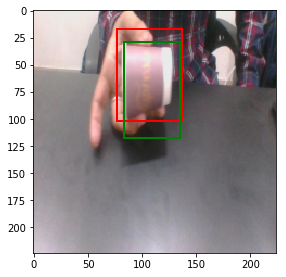

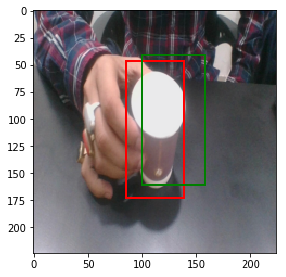

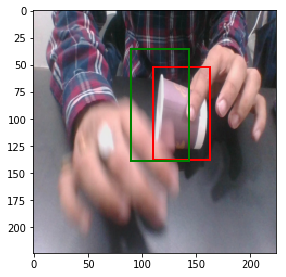

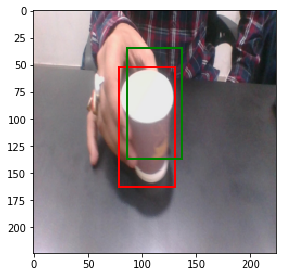

In [193]:
for img, box, pred_box in zip(imgs, boxes, pred_boxes):
    fig = plt.figure(figsize=(20,20))
    i = 0
    ax = plt.subplot(1, 4, i + 1)
    draw_bb(img, box, kind='tensor', normalized=True, testing=False)
    draw_bb(img, pred_box, kind='tensor', normalized=True, testing=True)
    plt.show()
    i+=1

## Saving model


In [194]:
# saving model
SAVE_PATH = 'model/model_loc.pth'
torch.save(model.state_dict(), SAVE_PATH)

In [195]:
def load_ckpt(ckpt_path):
    ckpt = torch.load(ckpt_path)
    
    model = models.densenet121(pretrained=False)
    for param in model.parameters():
        param.requires_grad = False

    # Put the regressor on the pretrained network
    fc_in_size = model.classifier.in_features
    model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(fc_in_size, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 4))
                          ]))
    
    model.load_state_dict(ckpt, strict=False)

    return model

In [196]:
# load model
model = load_ckpt(SAVE_PATH)

In [197]:
test_tfms = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224, 0.225])])

In [198]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an torch Tensor
    '''
    im = Image.open(image)
    return test_tfms(im)

In [199]:
img_path = 'test_data/2019-06-21-171650.jpg'
img_pros = process_image(img_path)

In [200]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

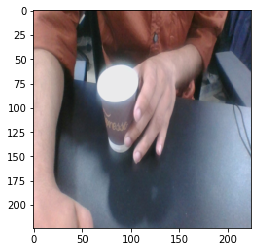

In [201]:
imshow(img_pros)

In [205]:
def predict(image_path, model):
    # Predict the class (or classes) of an image using a trained deep learning model.
    model.eval()
    img_pros = process_image(image_path)
    img_pros = img_pros.view(1,3,224,224)
    with torch.no_grad():
        output = model(img_pros)
    return output

In [206]:
box = predict(img_path, model)
box

tensor([[ 84.6256,  33.0001, 133.9382, 128.7454]])

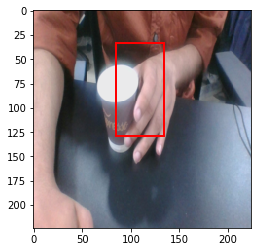

In [207]:
draw_bb(img_pros, box[0], kind='tensor', normalized=True, testing=False)